# Digital Twin v7.0: The Singularity Model

**Project Director:** Kian Mansouri Jamshidi
**AI Lead Engineer:** 

## 1. Mission Briefing

This notebook represents the culmination of our foundational research. After successfully gathering a 'pure state' hardware fingerprint with the 'Chronometer' (v13) data collection tool, we will now build the definitive Digital Twin.

**Core Objectives:**
1.  **Create a General-Purpose Model:** Train on the target-agnostic `snapshot_dataset_v_final.parquet` to ensure the model understands the hardware's fundamental physics.
2.  **Achieve State-of-the-Art Accuracy:** Employ a powerful **Stacked Ensemble** learning architecture to maximize the R² score.
3.  **Produce a Deployable Artifact:** The final, trained model will be serialized to disk, ready for integration into the COSMOS-Ω `PerformanceTitan`.

## 2. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import joblib
import copy
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# --- Path Definitions ---
PROJECT_ROOT = Path('.').resolve() # Assuming notebook is in project's root or `notebooks/` dir
if 'notebooks' in str(PROJECT_ROOT):
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / 'data' / 'telemetry_v3'
DATA_FILE = DATA_DIR / 'snapshot_dataset_v_final.parquet'
ARTIFACT_DIR = PROJECT_ROOT / 'artifacts' / 'phase2'
ENSEMBLE_DIR = ARTIFACT_DIR / 'digital_twin_v7.0_The_Singularity_Model'
ENSEMBLE_DIR.mkdir(exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Data File:    {DATA_FILE}")
print(f"Artifact Dir: {ENSEMBLE_DIR}")

Project Root: /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega
Data File:    /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega/data/telemetry_v3/snapshot_dataset_v_final.parquet
Artifact Dir: /home/kian/Desktop/Mega/ForgeX4-COSMOS-Omega/artifacts/phase2/digital_twin_v7.0_The_Singularity_Model


## 3. Data Loading & Exploratory Data Analysis (EDA)

Dataset Shape: (90, 6)

--- Dataset Head ---


,max_cpu_percent,avg_cpu_percent,max_resident_memory_bytes,avg_resident_memory_bytes,observation_duration_ms,workload_name
0,772.8,174.380952,107544576,5.990556e+07,1050,cpu_bound
1,812.5,176.795000,107167744,5.746504e+07,1000,cpu_bound
2,692.6,164.104762,107286528,6.235516e+07,1050,cpu_bound
3,833.0,175.409524,107274240,5.903409e+07,1050,cpu_bound
4,813.4,152.503571,107413504,6.994651e+07,1400,cpu_bound



--- Correlation Heatmap ---


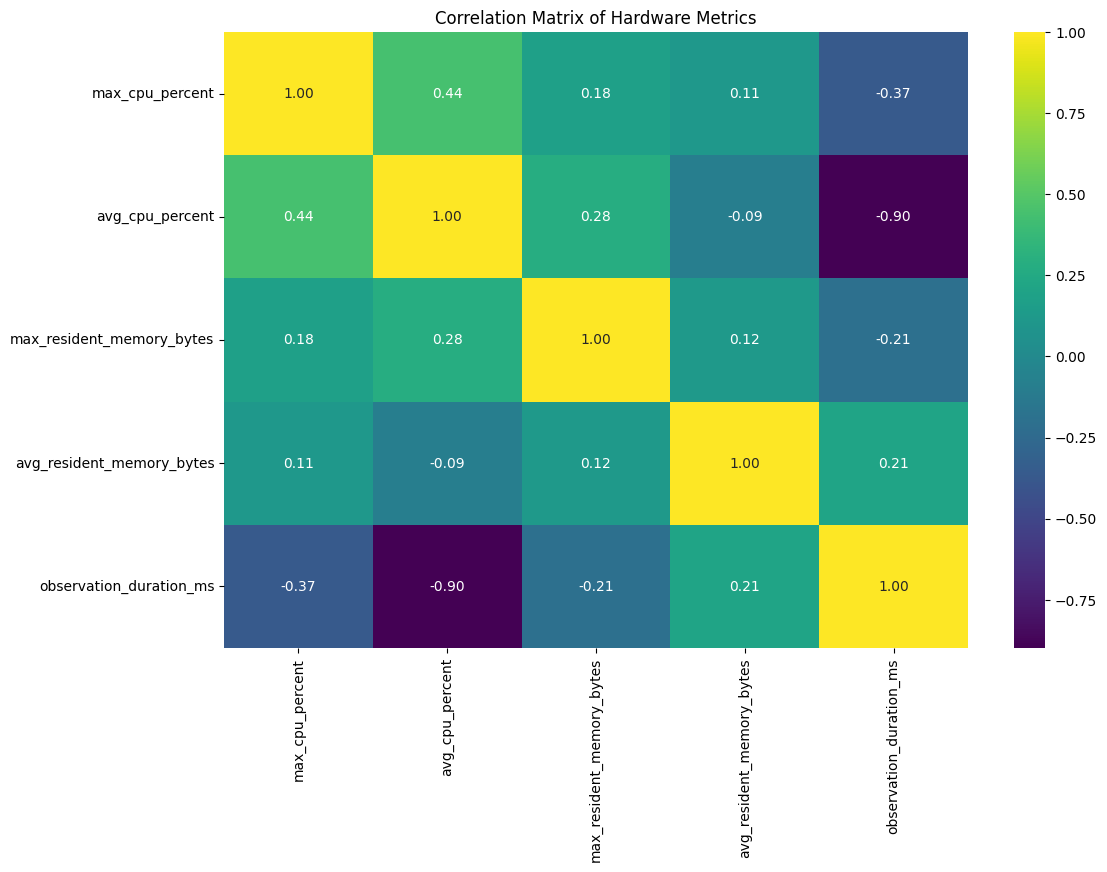


--- Target Distribution ---


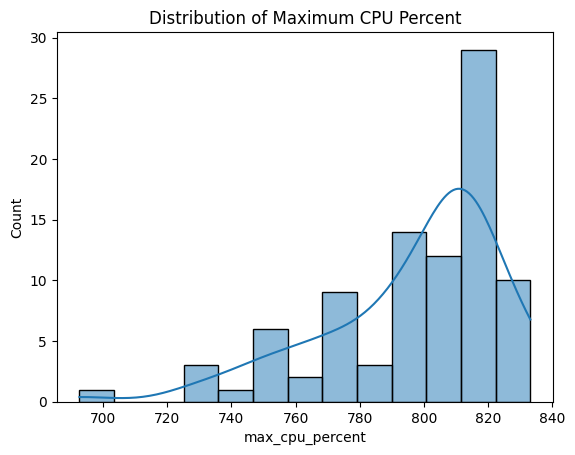

In [2]:
df = pd.read_parquet(DATA_FILE)

print("Dataset Shape:", df.shape)
print("\n--- Dataset Head ---")
display(df.head())

print("\n--- Correlation Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='viridis')
plt.title('Correlation Matrix of Hardware Metrics')
plt.show()

print("\n--- Target Distribution ---")
sns.histplot(df['max_cpu_percent'], kde=True)
plt.title('Distribution of Maximum CPU Percent')
plt.show()

## 4. Feature Engineering & Data Preparation

The core idea of the Singularity Model is to predict the **physical outcome** from the **workload type**. We will one-hot encode the `workload_name` to create our feature set (`X`) and define our primary performance metric, `max_cpu_percent`, as the target (`y`).

In [3]:
# One-Hot Encode the workload category
df_encoded = pd.get_dummies(df, columns=['workload_name'], prefix='workload')

# Define Features (X) and Target (y)
target_variable = 'max_cpu_percent'
features = [col for col in df_encoded.columns if col.startswith('workload_')]

X = df_encoded[features]
y = df_encoded[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Feature Set (X_train) ---")
display(X_train.head())
print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")

--- Feature Set (X_train) ---


,workload_cpu_bound,workload_io_bound,workload_memory_bound
49,False,True,False
62,False,False,True
73,False,False,True
69,False,False,True
76,False,False,True



Training data shape: (72, 3)
Testing data shape:  (18, 3)


## 5. Training the v7.0 Stacked Ensemble

This is the core of the notebook. We will build a powerful 2-layer stacked ensemble.

*   **Layer 0 (Base Models):** A diverse set of powerful tree-based models. Each will learn the relationship between workload type and performance in a different way.
*   **Layer 1 (Meta-Model):** A simple but effective linear model (`RidgeCV`) will learn how to best combine the predictions from the base models to produce a final, highly accurate prediction.

In [4]:
# --- Layer 0: Define a diverse set of powerful base models ---
base_models = [
    LGBMRegressor(random_state=42, n_jobs=-1),
    RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=150),
    ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=150),
    LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=123, n_jobs=-1)
]
base_model_names = ['LightGBM', 'RandomForest', 'ExtraTrees', 'LightGBM_tuned']

print("--- Training Final Base Models for Deployment ---")
final_base_models = [copy.deepcopy(m).fit(X_train, y_train) for m in base_models]
print("Base models trained.")

# --- Create the training set for the meta-model ---
meta_features_train = np.array([m.predict(X_train) for m in final_base_models]).T
print(f"\nMeta-features shape for training: {meta_features_train.shape}")

# --- Layer 1: Train the meta-model ---
print("\n--- Training Meta-Model ---")
meta_model = RidgeCV()
meta_model.fit(meta_features_train, y_train)
print("Meta-model trained.")

--- Training Final Base Models for Deployment ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 3
[LightGBM] [Info] Start training from score 795.968057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

## 6. Evaluation & Performance Analysis

We now evaluate the full ensemble on the held-out test set. We will measure its performance using the R² score, which indicates the proportion of the variance in the target variable that is predictable from the features.

--- Evaluating on Test Set ---

--- Final v7.0 SINGULARITY MODEL Performance ---
R-squared (R²): 0.0249
Root Mean Squared Error (RMSE): 23.86 CPU points


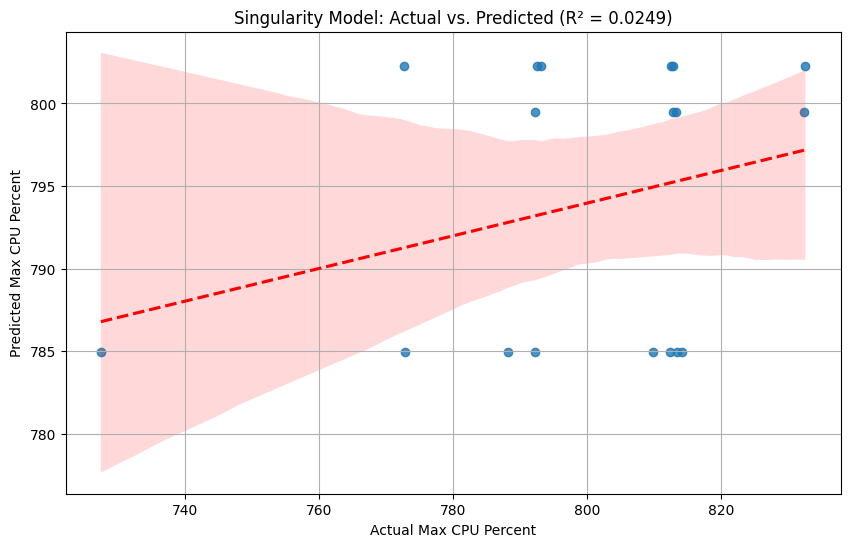

In [5]:
print("--- Evaluating on Test Set ---")
# 1. Get predictions from the base models on the test set
base_test_preds = np.array([m.predict(X_test) for m in final_base_models]).T

# 2. Use the meta-model to make the final prediction
final_predictions = meta_model.predict(base_test_preds)

# 3. Calculate the performance metrics
r2 = r2_score(y_test, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print("\n--- Final v7.0 SINGULARITY MODEL Performance ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} CPU points")

# --- Visualize the Results ---
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=final_predictions, line_kws={'color':'red', 'linestyle':'--'})
plt.xlabel('Actual Max CPU Percent')
plt.ylabel('Predicted Max CPU Percent')
plt.title(f'Singularity Model: Actual vs. Predicted (R² = {r2:.4f})')
plt.grid(True)
plt.show()

In [ ]:
print("--- Verifying the 'One Blue Dot' Phenomenon ---")
print("Unique values in the test set's target data (y_test):")
print(y_test.unique())

print("\nNumber of unique values:", len(y_test.unique()))

## 7. Serialize Artifacts for Deployment

The mission is complete. We now save the trained base models and the meta-model to disk. These `.joblib` files are the deployable artifacts that will be loaded by the `PerformanceTitan` to give it its predictive power.

In [ ]:
print(f"--- Saving Artifacts to: {ENSEMBLE_DIR} ---")

joblib.dump(final_base_models[0], ENSEMBLE_DIR / 'base_model_A.joblib')
joblib.dump(final_base_models[1], ENSEMBLE_DIR / 'base_model_B.joblib')
joblib.dump(final_base_models[2], ENSEMBLE_DIR / 'base_model_C.joblib')
joblib.dump(final_base_models[3], ENSEMBLE_DIR / 'base_model_D.joblib')
joblib.dump(meta_model, ENSEMBLE_DIR / 'meta_model.joblib')

print(f"All 5 model artifacts for the v7.0 Singularity Model have been saved.")
print("\n[bold green]MISSION COMPLETE: The Digital Twin is ready for integration.[/bold green]")